In [3]:
'''
purpose:
    according to the given number of ROIs N, pick up the top N ROIs accuracy and combine them for a combined mask and retrain the model and getting result

steps:
    load accuracy for all the ROIs for given subject
    pick up the top N ROIs
    combine these top N masks
    retrain the model and get the accuracy.

    get the N combinations of N-1 ROIs
    retrain the model and get the accuracy for these N combinations

    get the N-1 combinations of N-2 ROIs
    retrain the model and get the accuracy for these N-1 combinations


you could try to see whether combining parcels improves performance. 
That is going to be the most important bit, because we wi;ll want to decide on a tradeoff between number of voxels and accuracy. 
The script of interest here is aggregate.sh which is just a feeder for aggregate.py. 
This will use the .npy outputs of classRegion.py to select and merge the top N ROIs/parcels, and will return the list of ROI names, the number of voxels, and the cross-validated classifier accuracy 
in this newly combined larger mask. An example run of this is as follows:
sbatch aggregate.sh 0111171 neurosketch schaefer2018 15
'''

import os
print(f"conda env={os.environ['CONDA_DEFAULT_ENV']}") 
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch/")
import numpy as np
import nibabel as nib
import sys
import time
import pandas as pd
from sklearn.linear_model import LogisticRegression
import itertools
# from tqdm import tqdm
import pickle
import subprocess
from subprocess import call
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

# What subject are you running
'''
Takes args (in order):
    subject (e.g. 0111171)
    dataSource (e.g. neurosketch, but also realtime)
    roiloc (wang2014 or schaefer2018)
    N (the number of parcels or ROIs to start with)
'''

# subject,dataSource,roiloc,N=sys.argv[1],sys.argv[2],sys.argv[3],int(sys.argv[4])
subject,dataSource,roiloc,N="1130161","neurosketch","schaefer2018",78

print("Running subject {}, with {} as a data source, {}, starting with {} ROIs".format(subject, dataSource, roiloc, N))


# dataSource depending, there are a number of keywords to fill in: 
# ses: which day of data collection
# run: which run number on that day (single digit)
# phase: 12, 34, or 56
# sub: subject number
if dataSource == "neurosketch":
    funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
    anat = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/{sub}_neurosketch_anat_mprage_brain.nii.gz"
elif dataSource == "realtime":
    funcdata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/nifti/{sub}_functional.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/{sub}_0{run}_preprocessed_behavData.csv"
    anat = "$TO_BE_FILLED"
else:
    funcdata = "/gpfs/milgram/project/turk-browne/projects/rtTest/searchout/feat/{sub}_pre.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
    anat = "$TO_BE_FILLED"


workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
starttime = time.time()
tag="GM"
# '1201161', '1121161','0115172','0112174' #these subject have nothing in output folder
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
if roiloc == "schaefer2018":
    RESULT=np.zeros((len(subjects_correctly_aligned),300))
    topN = []
    for ii,sub in enumerate(subjects_correctly_aligned):
        outloc = workingDir+f"/{roiloc}/{sub}/output"
        for roinum in range(1,301):
            try:
                result = np.load(f"{outloc}/{roinum}_{tag}.npy")
                RESULT[ii,roinum-1]=result
            except:
                pass
            # RESULT = result if roinum == 1 else np.vstack((RESULT, result))
    RESULT = np.mean(RESULT,axis=0)
    print(f"RESULT.shape={RESULT.shape}")
    RESULTix = RESULT[:].argsort()[-N:]
    for idx in RESULTix:
        topN.append(f"{tag}_{idx+1}.nii.gz")
        # print(topN[-1])
else:
    RESULT_all=[]
    topN = []
    for ii,sub in enumerate(subjects_correctly_aligned):
        outloc = workingDir+"/{}/{}/output".format(roiloc, sub)
        for hemi in ["lh", "rh"]:
            for roinum in range(1, 26):
                # result = np.load("{}/roi{}_{}.npy".format(outloc, roinum, hemi))
                result = np.load(f"{outloc}/roi{roinum}_{hemi}_{tag}.npy")
                Result = result if roinum == 1 else np.vstack((Result, result))
            RESULT = Result if hemi == "lh" else np.hstack((RESULT, Result))
        RESULT_all.append(RESULT)

    RESULT_all=np.asarray(RESULT_all)
    print(f"RESULT_all.shape={RESULT_all.shape}")
    RESULT_all=np.mean(RESULT_all,axis=0)
    print(f"RESULT_all.shape={RESULT_all.shape}")
    RESULT1d = RESULT.flatten()
    RESULTix = RESULT1d.argsort()[-N:]
    x_idx, y_idx = np.unravel_index(RESULTix, RESULT.shape)

    # Check that we got the largest values.
    for x, y, in zip(x_idx, y_idx):
        print(x,y)
        if y == 0:
            topN.append(f"{tag}_roi{x+1}_lh.nii.gz")
        else:
            topN.append(f"{tag}_roi{x+1}_rh.nii.gz")
        # print(topN[-1])

print(f"len(topN)={len(topN)}")
print(f"topN={topN}")

def Wait(waitfor, delay=1):
    while not os.path.exists(waitfor):
        time.sleep(delay)
        print('waiting for {}'.format(waitfor))

def normalize(X):
    from scipy.stats import zscore
    # X = X - X.mean(0)
    X = zscore(X, axis=0)
    X[np.isnan(X)]=0
    return X

def Class(data, bcvar):
    metas = bcvar[0]
    data4d = data[0]
    print(data4d.shape)

    accs = []
    for run in range(6):
        testX = data4d[run]
        testY = metas[run]
        trainX = data4d[np.arange(6) != run]
        trainX = trainX.reshape(trainX.shape[0]*trainX.shape[1], -1)
        trainY = []
        for meta in range(6):
            if meta != run:
                trainY.extend(metas[meta])
        clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                 multi_class='multinomial').fit(trainX, trainY)
                
        # Monitor progress by printing accuracy (only useful if you're running a test set)
        acc = clf.score(testX, testY)
        accs.append(acc)
    
    return np.mean(accs)


phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}

def getMask(topN, subject):
    workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
    for pn, parc in enumerate(topN):
        _mask = nib.load(workingDir+"/{}/{}/{}".format(roiloc, subject, parc))
        aff = _mask.affine
        _mask = _mask.get_data()
        _mask = _mask.astype(int)
        # say some things about the mask.
        mask = _mask if pn == 0 else mask + _mask
        mask[mask>0] = 1
    return mask

mask=getMask(topN, subject)

print('mask dimensions: {}'. format(mask.shape))
print('number of voxels in mask: {}'.format(np.sum(mask)))

# Compile preprocessed data and corresponding indices
metas = []
for run in range(1, 7):
    print(run, end='--')
    # retrieve from the dictionary which phase it is, assign the session
    phase = phasedict[run]
    ses = 1
    
    # Build the path for the preprocessed functional data
    this4d = funcdata.format(ses=ses, run=run, phase=phase, sub=subject)
    
    # Read in the metadata, and reduce it to only the TR values from this run, add to a list
    thismeta = pd.read_csv(metadata.format(ses=ses, run=run, phase=phase, sub=subject))
    if dataSource == "neurosketch":
        _run = 1 if run % 2 == 0 else 2
    else:
        _run = run
    thismeta = thismeta[thismeta['run_num'] == int(_run)]
    
    if dataSource == "realtime":
        TR_num = list(thismeta.TR.astype(int))
        labels = list(thismeta.Item)
        labels = [imcodeDict[label] for label in labels]
    else:
        TR_num = list(thismeta.TR_num.astype(int))
        labels = list(thismeta.label)
    
    print("LENGTH OF TR: {}".format(len(TR_num)))
    # Load the functional data
    runIm = nib.load(this4d)
    affine_mat = runIm.affine
    runImDat = runIm.get_data()
    
    # Use the TR numbers to select the correct features
    features = [runImDat[:,:,:,n+3] for n in TR_num]
    features = np.array(features)
    # features = features[:, mask==1]
    print("shape of features", features.shape, "shape of mask", mask.shape)
    # featmean = features.mean(1).mean(1).mean(1)[..., None,None,None] #features.mean(1)[..., None]
    # features = features - featmean
    # features = features - features.mean(0)
    features = normalize(features)
    features = np.expand_dims(features, 0)
    
    # Append both so we can use it later
    metas.append(labels)
    runs = features if run == 1 else np.concatenate((runs, features))

dimsize = runIm.header.get_zooms()


# Preset the variables
print("Runs shape", runs.shape)
bcvar = [metas]
save_obj([bcvar,runs],f"./tmp__folder/{subject}_{dataSource}_{roiloc}_{N}") #{len(topN)}_{i}
                 
# # Distribute the information to the searchlights (preparing it to run)
# _runs = [runs[:,:,mask==1]]
# print("Runs shape", _runs[0].shape)
# slstart = time.time()
# sl_result = Class(_runs, bcvar)
# print("results of classifier: {}, type: {}".format(sl_result, type(sl_result)))
# SL = time.time() - slstart
# tot = time.time() - starttime
# print('total time: {}, searchlight time: {}'.format(tot, SL))

def wait(tmpFile):
    while not os.path.exists(tmpFile+'_result.npy'):
        time.sleep(5)
        print(f"waiting for {tmpFile}_result.npy\n")
    return np.load(tmpFile+'_result.npy')

def numOfRunningJobs():
    # subprocess.Popen(['squeue -u kp578 | wc -l > squeue.txt'],shell=True) # sl_result = Class(_runs, bcvar)
    randomID=str(time.time())
    # print(f"squeue -u kp578 | wc -l > squeue/{randomID}.txt")
    call(f'squeue -u kp578 | wc -l > squeue/{randomID}.txt',shell=True)
    numberOfJobsRunning = int(open(f"squeue/{randomID}.txt", "r").read())
    print(f"numberOfJobsRunning={numberOfJobsRunning}")
    return numberOfJobsRunning

if not os.path.exists(f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{len(topN)}.pkl"):
    _runs = [runs[:,:,mask==1]]
    print("Runs shape", _runs[0].shape)
    slstart = time.time()
    sl_result = Class(_runs, bcvar)

    save_obj({"subject":subject,
    "startFromN":N,
    "currNumberOfROI":len(topN),
    "bestAcc":sl_result, # this is the sl_result for the topN, not the bestAcc, bestAcc is for the purpose of keeping consistent with others
    "bestROIs":topN},# this is the topN, not the bestROIs, bestROIs is for the purpose of keeping consistent with others
    f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{len(topN)}"
    )
# ./tmp__folder/0125171_40_schaefer2018_neurosketch_39.pkl
if os.path.exists(f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{1}.pkl"):
    print(f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_1.pkl exists")
    raise Exception('runned or running')

# N-1
def next(topN): 
    print(f"len(topN)={len(topN)}")
    print(f"topN={topN}")

    if len(topN)==1:
        return None
    else:
        try:
            allpairs = itertools.combinations(topN,len(topN)-1)
            topNs=[]
            sl_results=[]
            tmpFiles=[]
            while os.path.exists("./tmp__folder/holdon.npy"):
                time.sleep(10)
                print("sleep for 10s ; waiting for ./tmp__folder/holdon.npy to be deleted")
            np.save("./tmp__folder/holdon",1)

            # 对于每一个round，提交一个job array，然后等待这个job array完成之后再进行下一轮
            # 具体的方法是首先保存需要的input，也就是这一轮需要用到的tmpFile，然后再将tmpFile除了之外的字符串输入
            for ii,_topN in enumerate(allpairs):
                tmpFile=f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{len(topN)}_{ii}"
                print(f"tmpFile={tmpFile}")
                topNs.append(_topN)
                tmpFiles.append(tmpFile)

                if not os.path.exists(tmpFile+'_result.npy'):

                    # prepare brain data(runs) mask and behavior data(bcvar) 

                    save_obj([_topN,subject,dataSource,roiloc,N], tmpFile)

                    # print("kp2")
                    # numberOfJobsRunning = numOfRunningJobs()
                    # print("kp3")
                    # while numberOfJobsRunning > 400: # 300 is not filling it up
                    #     print("kp4 300")
                    #     print("waiting 10, too many jobs running") ; time.sleep(10)
                    #     numberOfJobsRunning = numOfRunningJobs()
                    #     print("kp5")

                    # get the evidence for the current mask
                    
                else:
                    print(tmpFile+'_result.npy exists!')

            print(f'sbatch class.sh {tmpFile}')
            proc = subprocess.Popen([f'sbatch --array=1-{ii+1} class.sh {f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{len(topN)}_"}'], shell=True) # sl_result = Class(_runs, bcvar) 

            os.remove("./tmp__folder/holdon.npy")

            sl_results=[]
            for tmpFile in tmpFiles:
                sl_result=wait(tmpFile)
                sl_results.append(sl_result)
            print(f"sl_results={sl_results}")
            print(f"max(sl_results)=={max(sl_results)}")
            maxID=np.where(sl_results==max(sl_results))[0][0]
            save_obj({"subject":subject,
            "startFromN":N,
            "currNumberOfROI":len(topN)-1,
            "bestAcc":max(sl_results),
            "bestROIs":topNs[maxID]},
            f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{len(topN)-1}"
            )
            print(f"bestAcc={max(sl_results)} For {len(topN)-1} = ./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{len(topN)-1}")
            tmpFiles=next(topNs[maxID])
        except:
            return tmpFiles
tmpFiles=next(topN)



def Plot():
    # from glob import glob
    # import matplotlib.pyplot as plt
    # workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
    # roiloc="schaefer2018"
    # dataSource="neurosketch"
    # subjects=glob(workingDir+"/wang2014/[0,1]*")
    # subjects=[subject.split("/")[-1] for subject in subjects]

    # GreedyBestAcc=np.zeros((len(subjects),40))
    # for ii,subject in enumerate(subjects):            
    #     for len_topN_1 in range(40,0,-1):
    #         Wait(f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{len(topN)-1}.pkl")
    #         di = load_obj(f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}")
    #         GreedyBestAcc[ii,len_topN_1-1] = di['bestAcc']

    # plt.scatter(GreedyBestAcc,c='b',s=2)
        
    # To visualize the greedy result starting for 31 ROIs, in total 25 subjects.


    # # plt.savefig('SummaryAccuracy.png')
    import os
    os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch/")
    from glob import glob
    import matplotlib.pyplot as plt
    from tqdm import tqdm
    import pickle
    import subprocess
    def save_obj(obj, name):
        with open(name + '.pkl', 'wb') as f:
            pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    def load_obj(name):
        with open(name + '.pkl', 'rb') as f:
            return pickle.load(f)
    roiloc="schaefer2018"
    dataSource="neurosketch"
    # subjects=glob("./wang2014/[0,1]*")
    # subjects=[subject.split("/")[-1] for subject in subjects]
    subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
    subjects=subjects_correctly_aligned
    N=78
    workingPath="/gpfs/milgram/project/turk-browne/projects/rtTest/"
    GreedyBestAcc=np.zeros((len(subjects),N+1))
    GreedyBestAcc[GreedyBestAcc==0]=None
    for ii,subject in enumerate(subjects):
        try:
            GreedyBestAcc[ii,N]=np.load(workingPath+f"./{roiloc}/{subject}/output/uniMaskRank_{tag}_top{N}.npy")
        except:
            pass

        for len_topN_1 in range(N-1,0,-1):
            # Wait(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}.pkl")
            try:
                # print(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}")
                di = load_obj(f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}")
                GreedyBestAcc[ii,len_topN_1-1] = di['bestAcc']
            except:
                pass
    GreedyBestAcc=GreedyBestAcc.T
    plt.imshow(GreedyBestAcc)
    _=plt.figure()
    for i in range(GreedyBestAcc.shape[0]):
        plt.scatter([i]*GreedyBestAcc.shape[1],GreedyBestAcc[i],c='g',s=2)
    plt.plot(np.arange(GreedyBestAcc.shape[0]),np.nanmean(GreedyBestAcc,axis=1))
    # plt.ylim([0.19,0.36])
    # plt.xlabel("number of ROIs")
    # plt.ylabel("accuracy")


    _=plt.figure()
    for j in range(GreedyBestAcc.shape[1]):
        plt.plot(GreedyBestAcc[:,j])




conda env=/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud
Running subject 1130161, with neurosketch as a data source, schaefer2018, starting with 78 ROIs
RESULT.shape=(300,)
len(topN)=78
topN=['GM_234.nii.gz', 'GM_19.nii.gz', 'GM_225.nii.gz', 'GM_8.nii.gz', 'GM_86.nii.gz', 'GM_223.nii.gz', 'GM_159.nii.gz', 'GM_240.nii.gz', 'GM_148.nii.gz', 'GM_120.nii.gz', 'GM_195.nii.gz', 'GM_114.nii.gz', 'GM_222.nii.gz', 'GM_179.nii.gz', 'GM_65.nii.gz', 'GM_272.nii.gz', 'GM_235.nii.gz', 'GM_163.nii.gz', 'GM_56.nii.gz', 'GM_77.nii.gz', 'GM_108.nii.gz', 'GM_76.nii.gz', 'GM_284.nii.gz', 'GM_139.nii.gz', 'GM_295.nii.gz', 'GM_166.nii.gz', 'GM_271.nii.gz', 'GM_40.nii.gz', 'GM_164.nii.gz', 'GM_258.nii.gz', 'GM_151.nii.gz', 'GM_80.nii.gz', 'GM_89.nii.gz', 'GM_41.nii.gz', 'GM_214.nii.gz', 'GM_132.nii.gz', 'GM_249.nii.gz', 'GM_49.nii.gz', 'GM_259.nii.gz', 'GM_112.nii.gz', 'GM_21.nii.gz', 'GM_126.nii.gz', 'GM_58.nii.gz', 'GM_237.nii.gz', 'GM_218.nii.gz', 'GM_190.nii.gz', 'GM_186.nii.gz', 'GM_93.nii.

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:183: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 19202
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:226: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 94, 94, 72) shape of mask (94, 94, 72)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:226: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


2--LENGTH OF TR: 80
shape of features (80, 94, 94, 72) shape of mask (94, 94, 72)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:226: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 94, 94, 72) shape of mask (94, 94, 72)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:226: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 94, 94, 72) shape of mask (94, 94, 72)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:226: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 94, 94, 72) shape of mask (94, 94, 72)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:226: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 94, 94, 72) shape of mask (94, 94, 72)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


Runs shape (6, 80, 94, 94, 72)
Runs shape (6, 80, 19202)
(6, 80, 19202)
len(topN)=78
topN=['GM_234.nii.gz', 'GM_19.nii.gz', 'GM_225.nii.gz', 'GM_8.nii.gz', 'GM_86.nii.gz', 'GM_223.nii.gz', 'GM_159.nii.gz', 'GM_240.nii.gz', 'GM_148.nii.gz', 'GM_120.nii.gz', 'GM_195.nii.gz', 'GM_114.nii.gz', 'GM_222.nii.gz', 'GM_179.nii.gz', 'GM_65.nii.gz', 'GM_272.nii.gz', 'GM_235.nii.gz', 'GM_163.nii.gz', 'GM_56.nii.gz', 'GM_77.nii.gz', 'GM_108.nii.gz', 'GM_76.nii.gz', 'GM_284.nii.gz', 'GM_139.nii.gz', 'GM_295.nii.gz', 'GM_166.nii.gz', 'GM_271.nii.gz', 'GM_40.nii.gz', 'GM_164.nii.gz', 'GM_258.nii.gz', 'GM_151.nii.gz', 'GM_80.nii.gz', 'GM_89.nii.gz', 'GM_41.nii.gz', 'GM_214.nii.gz', 'GM_132.nii.gz', 'GM_249.nii.gz', 'GM_49.nii.gz', 'GM_259.nii.gz', 'GM_112.nii.gz', 'GM_21.nii.gz', 'GM_126.nii.gz', 'GM_58.nii.gz', 'GM_237.nii.gz', 'GM_218.nii.gz', 'GM_190.nii.gz', 'GM_186.nii.gz', 'GM_93.nii.gz', 'GM_67.nii.gz', 'GM_10.nii.gz', 'GM_209.nii.gz', 'GM_211.nii.gz', 'GM_230.nii.gz', 'GM_265.nii.gz', 'GM_52.ni

sl_results=[array(0.25625), array(0.26041667), array(0.26666667), array(0.25), array(0.25833333), array(0.26458333), array(0.26458333), array(0.25208333), array(0.25625), array(0.26041667), array(0.25625), array(0.2625), array(0.26041667), array(0.27083333), array(0.2625), array(0.25833333), array(0.25416667), array(0.25416667), array(0.24583333), array(0.25625), array(0.2625), array(0.25833333), array(0.26458333), array(0.25625), array(0.26458333), array(0.25833333), array(0.26666667), array(0.25625), array(0.25), array(0.25416667), array(0.25), array(0.25208333), array(0.26666667), array(0.25625), array(0.2625), array(0.25833333), array(0.25416667), array(0.26041667), array(0.25833333), array(0.25833333), array(0.26041667), array(0.25833333), array(0.26041667), array(0.26875), array(0.25625), array(0.26666667), array(0.26041667), array(0.25208333), array(0.27083333), array(0.25625), array(0.26458333), array(0.26666667), array(0.25833333), array(0.26041667), array(0.25416667), array(0

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_77_0_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_77_6_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_77_21_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_77_21_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_77_21_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_77_21_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_77_21_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_77_21_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_77_21_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_77_22_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_77_22_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_77_38_result.npy

waiting for ./tmp__folder/1130161_78_schae

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_76_0_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_76_0_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_76_0_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_76_0_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_76_0_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_76_0_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_76_8_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_76_21_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_76_21_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_76_21_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_76_21_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_76_21_result.npy

waiting for ./tmp__folder/1130161_78_schaefer20

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_75_0_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_75_0_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_75_0_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_75_0_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_75_0_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_75_0_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_75_10_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_75_21_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_75_21_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_75_21_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_75_21_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_75_21_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_74_0_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_74_0_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_74_0_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_74_0_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_74_0_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_74_0_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_74_8_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_74_8_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_74_8_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_74_8_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_74_21_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_neurosketch_74_21_result.npy

waiting for ./tmp__folder/1130161_78_schaefer2018_

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice


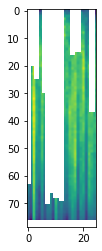

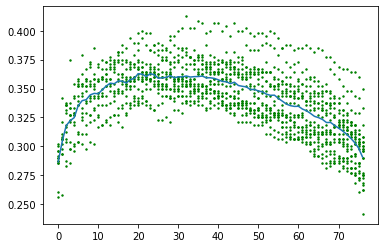

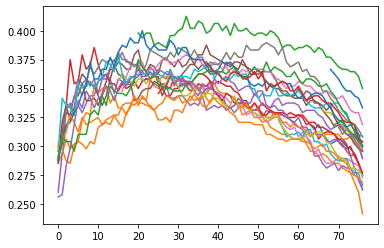

In [2]:
# # plt.savefig('SummaryAccuracy.png')
import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch/")
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import subprocess
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
roiloc="schaefer2018"
dataSource="neurosketch"
# subjects=glob("./wang2014/[0,1]*")
# subjects=[subject.split("/")[-1] for subject in subjects]
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
subjects=subjects_correctly_aligned
N=78
workingPath="/gpfs/milgram/project/turk-browne/projects/rtTest/"
GreedyBestAcc=np.zeros((len(subjects),N+1))
GreedyBestAcc[GreedyBestAcc==0]=None
for ii,subject in enumerate(subjects):
    try:
        GreedyBestAcc[ii,N]=np.load(workingPath+f"./{roiloc}/{subject}/output/uniMaskRank_{tag}_top{N}.npy")
    except:
        pass

    for len_topN_1 in range(N-1,0,-1):
        # Wait(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}.pkl")
        try:
            # print(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}")
            di = load_obj(f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}")
            GreedyBestAcc[ii,len_topN_1-1] = di['bestAcc']
        except:
            pass
GreedyBestAcc=GreedyBestAcc.T
plt.imshow(GreedyBestAcc)
_=plt.figure()
for i in range(GreedyBestAcc.shape[0]):
    plt.scatter([i]*GreedyBestAcc.shape[1],GreedyBestAcc[i],c='g',s=2)
plt.plot(np.arange(GreedyBestAcc.shape[0]),np.nanmean(GreedyBestAcc,axis=1))
# plt.ylim([0.19,0.36])
# plt.xlabel("number of ROIs")
# plt.ylabel("accuracy")


_=plt.figure()
for j in range(GreedyBestAcc.shape[1]):
    plt.plot(GreedyBestAcc[:,j])

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


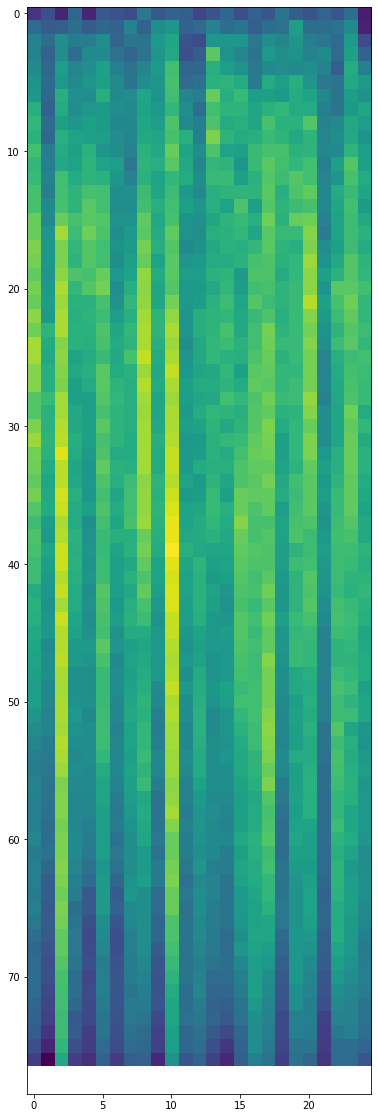

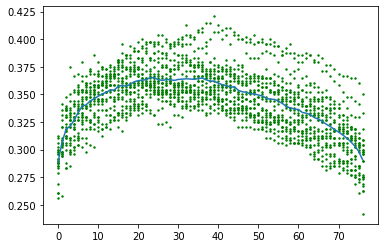

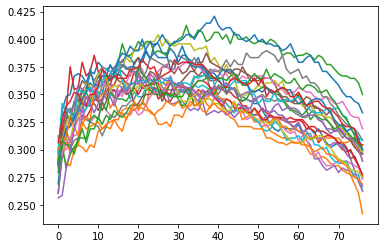

In [52]:
# # plt.savefig('SummaryAccuracy.png')
import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch/")
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle5 as pickle
import subprocess
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
roiloc="schaefer2018"
dataSource="neurosketch"
# subjects=glob("./wang2014/[0,1]*")
# subjects=[subject.split("/")[-1] for subject in subjects]
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
subjects=subjects_correctly_aligned
N=78
workingPath="/gpfs/milgram/project/turk-browne/projects/rtTest/"
GreedyBestAcc=np.zeros((len(subjects),N+1))
GreedyBestAcc[GreedyBestAcc==0]=None
for ii,subject in enumerate(subjects):
    try:
        GreedyBestAcc[ii,N]=np.load(workingPath+f"./{roiloc}/{subject}/output/uniMaskRank_{tag}_top{N}.npy")
    except:
        pass

    for len_topN_1 in range(N-1,0,-1):
        # Wait(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}.pkl")
        try:
            # print(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}")
            di = load_obj(f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}")
            GreedyBestAcc[ii,len_topN_1-1] = di['bestAcc']
        except:
            pass
GreedyBestAcc=GreedyBestAcc.T
plt.figure(figsize = (20,20))
# plt.imshow(random.rand(8, 90), interpolation='nearest')
plt.imshow(GreedyBestAcc, interpolation='nearest')
_=plt.figure()
for i in range(GreedyBestAcc.shape[0]):
    plt.scatter([i]*GreedyBestAcc.shape[1],GreedyBestAcc[i],c='g',s=2)
plt.plot(np.arange(GreedyBestAcc.shape[0]),np.nanmean(GreedyBestAcc,axis=1))
# plt.ylim([0.19,0.36])
# plt.xlabel("number of ROIs")
# plt.ylabel("accuracy")


_=plt.figure()
for j in range(GreedyBestAcc.shape[1]):
    plt.plot(GreedyBestAcc[:,j])
    
for i,sub in enumerate(subjects):
    if np.isnan(GreedyBestAcc[:,i][0]):
        print(f"sbatch --requeue aggregate_greedy.sh {sub} neurosketch schaefer2018 78")


In [53]:
for i,sub in enumerate(subjects):
    if np.isnan(GreedyBestAcc[:,i][0]):
        print(f"sbatch --requeue aggregate_greedy.sh {sub} neurosketch schaefer2018 78")
